## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* **Apply a perspective transform to rectify binary image ("birds-eye view").**
* Detect lane pixels and fit to find the lane boundary.|
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

def show_images(images, rows = 5, cols = 4, figsize=(15,10), cmap = None):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap=cmap)
            ax.set_title(imagePathName)
            ax.axis('off')

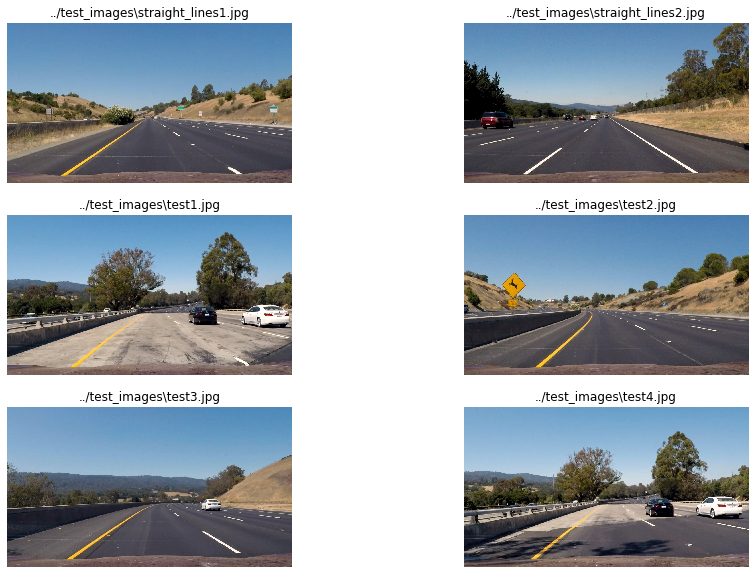

In [2]:
# Loading all test images and display them
images = glob.glob('../test_images/*.jpg')
img = list(map(lambda imageFileName: (imageFileName, cv2.cvtColor(cv2.imread(imageFileName),cv2.COLOR_BGR2RGB)), images))

show_images(img, cols=2, rows=3) 

### Applying perpective transformation

https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html

(-0.5, 1279.5, 719.5, -0.5)

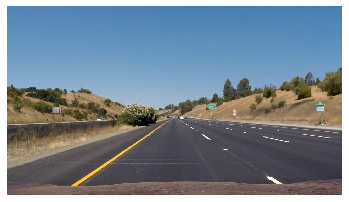

In [3]:
# Loading the camera calibration
cameraCalib = pickle.load(open('serialized_camera_calibration/camera_calibration.p','rb'))
mtx, dist = map(cameraCalib.get, ('mtx','dist'))

## Getting the 4 points for perspective transform
duplicate = img[0][1].copy()
undistort = cv2.undistort(duplicate, mtx, dist, None, mtx)
plt.imshow(duplicate)
plt.axis("off")

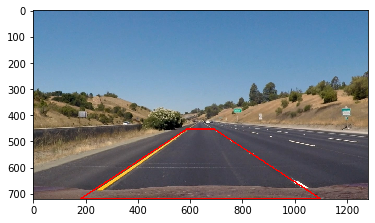

In [4]:
# Drawing the line for visualization

# Region-of-interest vertices for perfect symmetry trapezoid
trap_height_percentage = 0.63
trap_bottom_width_offset = 0.14
trap_top_width_offset = 0.459

imshape = duplicate.shape
height = imshape[0]
width = imshape[1]

top_left = [int(width * trap_top_width_offset), int(height * trap_height_percentage)]
top_right = [int(width * (1-trap_top_width_offset)), int(height * trap_height_percentage)]
btm_left = [int(width * trap_bottom_width_offset), height]
btm_right = [int(width * (1-trap_bottom_width_offset)), height]
line_width = 3
color = [255,0,0]

cv2.line(duplicate, tuple(top_left), tuple(top_right), color, line_width)
cv2.line(duplicate, tuple(btm_left), tuple(top_left), color, line_width)
cv2.line(duplicate, tuple(btm_left), tuple(btm_right), color, line_width)
cv2.line(duplicate, tuple(top_right), tuple(btm_right), color, line_width)

plt.imshow(duplicate)

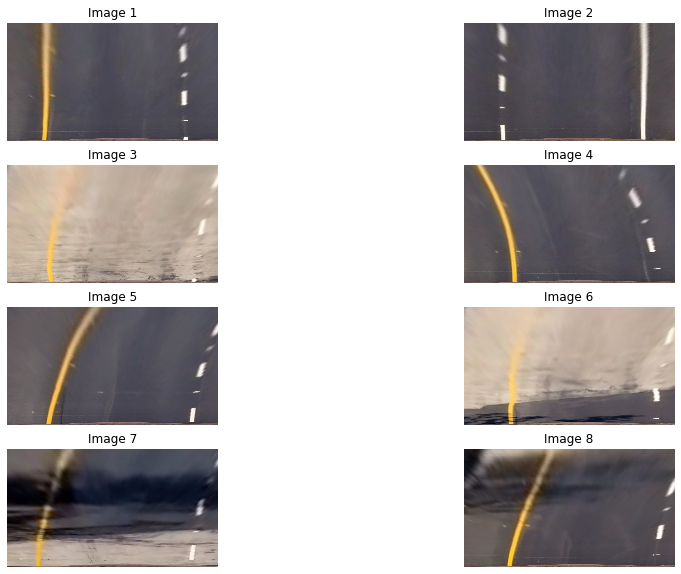

In [5]:
# Creating a dst for inverse matrix, making it grayscale for easy computation
gray = cv2.cvtColor(undistort,cv2.COLOR_BGR2GRAY)

img_size = (gray.shape[1],gray.shape[0])
offset = 200

src = np.float32([top_left,top_right,btm_right,btm_left])
dst = np.float32([[offset, 0], [img_size[0] - offset, 0],
                  [img_size[0] - offset, img_size[1]],[offset,img_size[1]]])

M = cv2.getPerspectiveTransform(src,dst)
inv_M = cv2.cv2.getPerspectiveTransform(dst,src)

warped = []

for i in range(0,len(img)):
    undistort = cv2.undistort(img[i][1], mtx, dist, None, mtx)
    warped.append(('Image ' + str(i+1),cv2.warpPerspective(undistort, M, img_size)))
    
show_images(warped, cols=2, rows=4) 
    

In [6]:
pickle.dump( {'M': M, 'inv_M': inv_M }, open('perspective_xform_calibration/pt_calibration.p','wb'))

print('Transformation matrix: ')
print(M)
print('Transformation inverse matrix: ')
print(inv_M)

Transformation matrix: 
[[-6.87795839e-01 -1.52874744e+00  1.07984544e+03]
 [-4.13406683e-16 -1.94114393e+00  8.79338198e+02]
 [-2.28011335e-19 -2.38866788e-03  1.00000000e+00]]
Transformation inverse matrix: 
[[ 1.19318182e-01 -7.86934491e-01  5.63136364e+02]
 [ 0.00000000e+00 -5.15160152e-01  4.53000000e+02]
 [ 0.00000000e+00 -1.23054651e-03  1.00000000e+00]]
